# Getting set up in Colab: 
First, we need to install the required packages for this tutorial into our colab session. This could take a few moments to install

**If you are running this locally, you should use the other notebook -- not the one that starts with colab_** 

In [ ]:
%%bash
pip install -r requirements.txt

In [9]:
import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
%load_ext autoreload
%autoreload 2
from scipy import stats
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List, Tuple, Optional, Union
import random
from brainiak.funcalign import srm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from nilearn import datasets, surface
import nibabel as nib
import nilearn
import matplotlib.colors as mcolors

random.seed(4)
np.random.seed(4)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Including functions and classes here for use in colab 
if running locally, use the other functional_alignment_example notebook

## Functions from `demo_data_helpers.py`

In [10]:

def load_sherlock_labels():
    return np.load('sample_data/sherlock_indoor_scene_labels.npy')
    
def load_rsfmri(n_subjects, save_to="./sample_data", seed_region=16, verbose=1):
    if save_to:
        outpath = f'{save_to}/demo_rsfmri_data_{n_subjects}_subjects_seed_{seed_region}.pkl'
        if os.path.exists(outpath):
            with open(outpath, 'rb') as f:
                loaded_data = pickle.load(f)
            return loaded_data
        
    parcellated, region = process_rsfmri_demo_subjects_destrieux(n_subjects=n_subjects, region_id=seed_region, data_dir=None, verbose=verbose)
    loaded_data = {'parcellated_all': parcellated, 'region_all':region}
    if save_to:
        with open(outpath, 'wb') as f:
            pickle.dump(loaded_data, f)
    return loaded_data

def load_sherlock_movie():
    return np.load(f'./sample_data/sherlock_movie_data_early_visual_roi.npy')

def load_simulated_data_manifold_example():
    loaded_data = {'input_data':np.load('./sample_data/input_data.npy'), 
                  'exogenous_data':np.load('./sample_data/exogenous_features.npy'),
                  'scores':np.load('./sample_data/scores.npy')}
    return loaded_data

def compute_connectivity_matrix(m1, m2):
    cnx = 1-cdist(m1, m2, 'correlation')
    return cnx
    

def plot_3d_datasets(datasets, dataset_names=None, feature_names=None, title='',
                     figsize=(6,4), marker='o', alpha=0.7, s=20, 
                     view_angles=(30, 45), save_path=None):
    """
    Plot multiple datasets in a 3D scatterplot with different colors for each dataset.
    
    Parameters:
    -----------
    datasets : list of numpy arrays
        List containing N datasets, where each dataset is a numpy array of shape (S, 3)
        with S samples and 3 features.
    
    dataset_names : list of str, optional
        Names for each dataset to be shown in the legend. If None, datasets will be labeled
        as "Participant 1", "Participant 2", etc.
        
    feature_names : list of str, optional
        Names for the three features (x, y, z axes). If None, features will be labeled
        as "Feature 1", "Feature 2", "Feature 3".
    
    title : str, optional
        Title for the plot
        
    figsize : tuple, optional
        Figure size as (width, height) in inches.
    
    marker : str, optional
        Marker style for the scatter plot.
    
    alpha : float, optional
        Transparency of the markers (0 to 1).
    
    s : int, optional
        Marker size.
    
    view_angles : tuple, optional
        Initial view angles (elevation, azimuth) in degrees.
    
    save_path : str, optional
        If provided, saves the figure to the specified path.
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
        The figure and axis objects for further customization if needed.
    """
    # Validate inputs
    sns.set_context('paper')

    if not isinstance(datasets, list):
        raise TypeError("datasets must be a list of numpy arrays")
    
    for i, dataset in enumerate(datasets):
        if dataset.shape[1] != 3:
            raise ValueError(f"Participant {i+1} has {dataset.shape[1]} features, expected 3 features")
    
    # Set default names if not provided
    if dataset_names is None:
        dataset_names = [f"Participant {i+1}" for i in range(len(datasets))]
    elif len(dataset_names) != len(datasets):
        raise ValueError("Number of dataset names must match number of datasets")
    
    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(3)]
    elif len(feature_names) != 3:
        raise ValueError("Must provide exactly 3 feature names")
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Get a color cycle for the datasets
    colors = list(mcolors.TABLEAU_COLORS)  # Using Tableau colors
    # If we have more datasets than colors, we'll cycle through the colors
    if len(datasets) > len(colors):
        colors = colors * (len(datasets) // len(colors) + 1)
    
    # Plot each dataset with a different color
    for i, dataset in enumerate(datasets):
        ax.scatter(
            dataset[:, 0], dataset[:, 1], dataset[:, 2],
            c=colors[i], marker=marker, alpha=alpha, s=s,
            label=dataset_names[i]
        )
    
    # Set labels and title
    ax.set_xlabel(feature_names[0])
    ax.set_xticks([])
    ax.set_ylabel(feature_names[1])
    ax.set_yticks([])
    ax.set_zlabel(feature_names[2])
    ax.set_zticks([])
    ax.set_title(f"{title}")
    
    # Add legend
    ax.legend()
    
    # Set the viewing angle
    ax.view_init(elev=view_angles[0], azim=view_angles[1])
    
    # Add grid
    ax.grid(False)
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

def plot_3d_trajectories(trajectories, trajectory_names=None, feature_names=None, title='',
                         figsize=(6,4), linewidth=2, alpha=0.8, linestyle='-',
                         markers=None, marker_size=20, marker_frequency=None,
                         view_angles=(30, 45), save_path=None):
    """
    Plot multiple trajectories (lines) in 3D space, each with a different color.
    
    Parameters:
    -----------
    trajectories : list of numpy arrays
        List containing N trajectories, where each trajectory is a numpy array of shape (S, 3)
        with S samples and 3 features, representing points along a path in 3D space.
    
    trajectory_names : list of str, optional
        Names for each trajectory to be shown in the legend. If None, trajectories will be labeled
        as "Participant 1", "Participant 2", etc.
        
    feature_names : list of str, optional
        Names for the three features (x, y, z axes). If None, features will be labeled
        as "Feature 1", "Feature 2", "Feature 3".
    
    title : str, optional
        title of plot
    
    figsize : tuple, optional
        Figure size as (width, height) in inches.
    
    linewidth : float, optional
        Width of the trajectory lines.
    
    alpha : float, optional
        Transparency of the lines (0 to 1).
    
    linestyle : str, optional
        Style of the trajectory lines ('-', '--', '-.', ':', etc.).
    
    markers : str or list, optional
        Marker style for points along the trajectory. If None, no markers are shown.
        If a string, the same marker is used for all trajectories.
        If a list, each trajectory can have a different marker.
    
    marker_size : int, optional
        Size of markers if markers are shown.
    
    marker_frequency : int, optional
        If provided, show markers every marker_frequency points along the trajectory.
        If None and markers are provided, markers are shown at every point.
    
    view_angles : tuple, optional
        Initial view angles (elevation, azimuth) in degrees.
    
    save_path : str, optional
        If provided, saves the figure to the specified path.
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
        The figure and axis objects for further customization if needed.
    """
    # Validate inputs
    if not isinstance(trajectories, list):
        raise TypeError("trajectories must be a list of numpy arrays")
    
    for i, trajectory in enumerate(trajectories):
        if trajectory.shape[1] != 3:
            raise ValueError(f"Participant {i+1} has {trajectory.shape[1]} features, expected 3 features")
    
    # Set default names if not provided
    if trajectory_names is None:
        trajectory_names = [f"Participant {i+1}" for i in range(len(trajectories))]
    elif len(trajectory_names) != len(trajectories):
        raise ValueError("Number of trajectory names must match number of trajectories")
    
    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(3)]
    elif len(feature_names) != 3:
        raise ValueError("Must provide exactly 3 feature names")
    
    # Handle markers
    if markers is not None and not isinstance(markers, list):
        markers = [markers] * len(trajectories)
    elif markers is not None and len(markers) != len(trajectories):
        markers = markers * (len(trajectories) // len(markers) + 1)
        markers = markers[:len(trajectories)]
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Get a color cycle for the trajectories
    colors = list(mcolors.TABLEAU_COLORS)  # Using Tableau colors
    # If we have more trajectories than colors, we'll cycle through the colors
    if len(trajectories) > len(colors):
        colors = colors * (len(trajectories) // len(colors) + 1)
    
    # Plot each trajectory with a different color
    for i, trajectory in enumerate(trajectories):
        # Plot the line
        ax.plot(
            trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
            c=colors[i], linewidth=linewidth, alpha=alpha, linestyle=linestyle,
            label=trajectory_names[i]
        )
        
        # Add markers if requested
        if markers is not None:
            if marker_frequency is not None:
                # Show markers at specified frequency
                idx = np.arange(0, len(trajectory), marker_frequency)
                marker_data = trajectory[idx]
            else:
                # Show markers at every point
                marker_data = trajectory
                
            ax.scatter(
                marker_data[:, 0], marker_data[:, 1], marker_data[:, 2],
                c=colors[i], marker=markers[i], s=marker_size
            )
    
    # Set labels and title
    ax.set_xlabel(feature_names[0])
    ax.set_xticks([])
    ax.set_ylabel(feature_names[1])
    ax.set_yticks([])
    ax.set_zlabel(feature_names[2])
    ax.set_zticks([])
    ax.set_title(f"{title}")
    
    # Add legend
    ax.legend()
    
    # Set the viewing angle
    ax.view_init(elev=view_angles[0], azim=view_angles[1])
    
    # Add grid
    ax.grid(False)
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax


## Functions from `load_demo_rsfmri.py`

In [11]:
def download_subjects_data(n_subjects=10, data_dir=None, verbose=0):
    """
    Download surface data for n_subjects from the NKI enhanced dataset.
    
    Parameters
    ----------
    n_subjects : int, default=10
        Number of subjects to download.
    data_dir : str, optional
        Directory where data should be downloaded.
        
    Returns
    -------
    list of dicts
        Each dict contains paths to the surface data of a subject.
    """
    if verbose: print(f"Downloading data for {n_subjects} subjects...")
    
    # Fetch data for all subjects
    nki_data = datasets.fetch_surf_nki_enhanced(n_subjects=n_subjects, data_dir=data_dir)
    
    # Extract only the first n_subjects
    subjects_data = []
    for i in range(n_subjects):
        subject_data = {
            'func_left': np.nan_to_num(nki_data.func_left[i]),
            'func_right': np.nan_to_num(nki_data.func_right[i])
        }
        subjects_data.append(subject_data)
    
    if verbose: print(f"Downloaded {len(subjects_data)} subjects' data.")
    return subjects_data

def fetch_destrieux_atlas(data_dir=None):
    """
    Fetch the Destrieux atlas.
    
    Parameters
    ----------
    data_dir : str, optional
        Directory where data should be downloaded.
        
    Returns
    -------
    dict
        Dictionary containing the atlas data.
    """
    print("Fetching Destrieux atlas...")
    
    # Fetch the fsaverage5 surface and Destrieux parcellation
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5', data_dir=data_dir)
    
    # Load the Destrieux parcellation
    destrieux = datasets.fetch_atlas_surf_destrieux(data_dir=data_dir)
    
    atlas = {
        'parcellation_left': destrieux['map_left'],
        'parcellation_right': destrieux['map_right'],
        'labels': destrieux['labels'],
        'mesh_left': fsaverage.pial_left,
        'mesh_right': fsaverage.pial_right
    }
    
    print(f"Fetched Destrieux atlas with {len(atlas['labels'])} regions.")
    return atlas

def extract_surface_data(subject_data):
    """
    Extract surface functional data from a subject.
    
    Parameters
    ----------
    subject_data : dict
        Dictionary containing paths to subject's data.
        
    Returns
    -------
    tuple
        (left_data, right_data) numpy arrays of shape (n_vertices, n_timepoints)
    """
    # Load left and right hemisphere data
    left_data = surface.load_surf_data(subject_data['func_left'])
    right_data = surface.load_surf_data(subject_data['func_right'])
    
    # Transpose to shape (n_vertices, n_timepoints)
    if left_data.shape[0] < left_data.shape[1]:
        left_data = left_data.T
    if right_data.shape[0] < right_data.shape[1]:
        right_data = right_data.T
    
    return left_data, right_data

def load_atlas_labels(atlas):
    """
    Load atlas labels for left and right hemispheres.
    
    Parameters
    ----------
    atlas : dict
        Atlas data returned.
    mesh_left : str
        Path to left hemisphere mesh.
    mesh_right : str
        Path to right hemisphere mesh.
        
    Returns
    -------
    tuple
        (left_labels, right_labels) containing label arrays for each hemisphere.
    """
    # Load the fsaverage5 surface
    fsaverage = datasets.fetch_surf_fsaverage()
    
    # Map the atlas from MNI volume to fsaverage5 surface
    labels_left = surface.vol_to_surf(
        atlas.maps, fsaverage.pial_left
    )
    labels_right = surface.vol_to_surf(
        atlas.maps, fsaverage.pial_right
    )
    
    return labels_left, labels_right

def parcellate_hemisphere_data(hemisphere_data, hemisphere_labels):
    """
    Parcellate data for a single hemisphere using the provided labels.
    
    Parameters
    ----------
    hemisphere_data : numpy.ndarray
        Hemisphere data with shape (n_vertices, n_timepoints).
    hemisphere_labels : numpy.ndarray
        Labels array for the hemisphere.
        
    Returns
    -------
    tuple
        (parcellated_data, unique_rois) where:
        - parcellated_data has shape (n_timepoints, n_rois)
        - unique_rois is a list of unique region IDs
    """
    # Get number of timepoints
    n_timepoints = hemisphere_data.shape[1]
    
    # Get unique ROIs (exclude 0 which is typically background)
    unique_rois = np.unique(hemisphere_labels)
    unique_rois = unique_rois[unique_rois != 0]
    n_rois = len(unique_rois)
    
    # Initialize parcellated data
    parcellated_data = np.zeros((n_timepoints, n_rois))
    
    # Maps from ROI value to index in parcellated_data
    roi_to_idx = {roi: i for i, roi in enumerate(unique_rois)}
    
    # Parcellate hemisphere
    for roi in unique_rois:
        roi_mask = hemisphere_labels == roi
        if np.any(roi_mask):
            roi_data = hemisphere_data[roi_mask, :]
            idx = roi_to_idx[roi]
            parcellated_data[:, idx] = np.mean(roi_data, axis=0)
    
    return parcellated_data

def parcellate_data_separate_hemispheres(subject_data, atlas):
    """
    Parcellate subject's data using the Destrieux atlas, keeping hemispheres separate.
    
    Parameters
    ----------
    subject_data : dict
        Dictionary containing paths to subject's data.
    atlas : dict
        Atlas data returned by fetch_destrieux_atlas.
        
    Returns
    -------
    dict
        Dictionary containing parcellated data and ROI information for each hemisphere.
    """
    # Extract surface data
    left_data, right_data = extract_surface_data(subject_data)
    
    # Get labels from left and right hemispheres
    labels_left = np.array(atlas['parcellation_left'])
    labels_right = np.array(atlas['parcellation_right'])
    
    # Parcellate left hemisphere
    parcellated_left = parcellate_hemisphere_data(left_data, labels_left)
    
    # Parcellate right hemisphere
    parcellated_right = parcellate_hemisphere_data(right_data, labels_right)
    
    return parcellated_left, parcellated_right
    


def extract_region_data_separate_hemispheres(subject_data, atlas, region_id):
    """
    Extract multivariate data from a specific region, keeping hemispheres separate.
    
    Parameters
    ----------
    subject_data : dict
        Dictionary containing paths to subject's data.
    atlas : dict
        Atlas data returned by fetch_destrieux_atlas.
    region_id : int, default=16
        Region ID to extract.
        
    Returns
    -------
    dict
        Dictionary containing region data for each hemisphere.
    """
    # Extract surface data
    left_data, right_data = extract_surface_data(subject_data)
    
    # Get labels from left and right hemispheres
    labels_left = np.array(atlas['parcellation_left'])
    labels_right = np.array(atlas['parcellation_right'])
    
    # Extract vertices from the specified region for each hemisphere
    region_mask_left = left_data[labels_left == region_id,:]
    region_mask_right = right_data[labels_right == region_id,:]
    
    return region_mask_left.T, region_mask_right.T
    
def get_region_name(atlas, region_id):
    """
    Get the name of a region by its ID.
    
    Parameters
    ----------
    atlas : dict
        Atlas data returned by fetch_destrieux_atlas.
    region_id : int
        Region ID.
        
    Returns
    -------
    str
        Region name.
    """
    label = atlas['labels'][region_id+1].decode() # account for background
    return label

def process_rsfmri_demo_subjects_destrieux(n_subjects=10, region_id=16, data_dir=None, verbose=0):
    """
    Process data for multiple subjects using the Destrieux atlas,
    keeping hemispheres separate.
    
    Parameters
    ----------
    n_subjects : int, default=10
        Number of subjects to process.
    region_id : int, default=16
        Region ID to extract data from.
    data_dir : str, optional
        Directory where data should be downloaded.
        
    Returns
    -------
    dict
        Dictionary containing processed data for each hemisphere.
    """
    # Download data for subjects
    subjects_data = download_subjects_data(n_subjects=n_subjects, data_dir=data_dir)
    
    # Fetch Destrieux atlas
    atlas = fetch_destrieux_atlas(data_dir=data_dir)
    
    # Check if the specified region exists in the atlas
    region_name = get_region_name(atlas, region_id)
    print(f"Target region: {region_name}")
    
    # Initialize dictionaries to store results
    parcellated_all, region_all = [],[]
    
    # Process each subject
    for i, subject_data in enumerate(tqdm(subjects_data, desc="Processing subjects")):
        # Parcellate data
        parcellated_left, parcellated_right = parcellate_data_separate_hemispheres(subject_data, atlas)
        
        # Extract region data
        region_data_left, region_data_right = extract_region_data_separate_hemispheres(subject_data, atlas, region_id=region_id)
        if verbose: print(f'subject {i+1} parcellated data of shape: {parcellated_left.shape}, {parcellated_right.shape}')
        if verbose: print(f'subject {i+1} parcellated data of shape: {region_data_left.shape}, {region_data_right.shape}')
        # Normalize data
        parcellated_left_norm = np.nan_to_num(scipy.stats.zscore(parcellated_left, axis=0))
        parcellated_right_norm = np.nan_to_num(scipy.stats.zscore(parcellated_right, axis=0))
        region_left_norm = np.nan_to_num(scipy.stats.zscore(region_data_left, axis=0))
        region_right_norm = np.nan_to_num(scipy.stats.zscore(region_data_right, axis=0))
        
        # Stack left and right together
        parcellated_bh = np.hstack([parcellated_left_norm, parcellated_right_norm])
        region_bh = np.hstack([region_left_norm, region_right_norm])
        if verbose: print(f'after stacking: {parcellated_bh.shape}, {region_bh.shape}')
        parcellated_all.append(parcellated_bh)
        region_all.append(region_bh)
        
    return parcellated_all, region_all

## Class from `hyperalignment.py`

In [12]:
class Hyperalignment(BaseEstimator, TransformerMixin):
    """
    Hyperalignment transformer that follows scikit-learn's API conventions.
    
    Parameters
    ----------
    n_iter : int, default=10
        Maximum number of iterations for hyperalignment optimization.
    
    scaling : bool, default=True
        Whether to apply scaling during Procrustes transformations.
    
    convergence_threshold : float, default=0.1
        Early stopping threshold for mean disparity between aligned datasets.
    
    verbose : bool, default=False
        If True, print progress during iterations.
    
    Attributes
    ----------
    transformations : list
        List of transformation matrices for each dataset.
    
    template : ndarray
        Common template space derived from training data.
    
    n_features_in : int
        Number of features in the input datasets.
        
    n_features_target: int
    
    aligned_data : list
        List of datasets aligned to the common space.
    
    n_iterations_ : int
        Number of iterations performed during training.
    """
    
    def __init__(self, n_iterations=10, scaling=True, center_only=True, convergence_threshold=0.001, n_features_target=0, verbose=False): 
        self.n_iterations = n_iterations
        self.scaling = scaling
        self.convergence_threshold = convergence_threshold
        self.verbose = verbose
        self.training_data = None
        self.n_features_target = n_features_target
        self.center_only = center_only
    
    def _normalize_data(self, X: np.ndarray) -> np.ndarray:
        """
        Normalize data by centering and scaling.
        
        Parameters
        ----------
        X : ndarray
            Input data matrix.
            
        Returns
        -------
        ndarray
            Normalized data matrix.
        """
        X -= np.mean(X, axis=0)
        norm = np.linalg.norm(X)
        if norm == 0: 
            raise ValueError("input matrix must have >1 unique points")
        if self.center_only:
            return X
        return  X / norm
    
    def _disparity(self, M1: np.ndarray, M2: np.ndarray) -> float:
        """
        Calculate squared Euclidean distance between two matrices.
        
        Parameters
        ----------
        M1 : ndarray
            First data matrix.
        M2 : ndarray
            Second data matrix.
            
        Returns
        -------
        float
            Sum of squared differences between matrices.
        """
        return np.sum(np.square(M1 - M2))
    
    def _procrustes(self, source: np.ndarray, target: np.ndarray, 
                   reduction: bool = False, scaling: Optional[bool] = None) -> Tuple:
        """
        Perform Procrustes transformation to align source to target.
        
        Parameters
        ----------
        source : ndarray
            Source data matrix to be aligned.
        target : ndarray
            Target data matrix to align to.
        reduction : bool, default=False
            If True, reduce dimensions if source and target have different numbers of features.
        scaling : bool, optional
            Whether to apply scaling. If None, use self.scaling.
            
        Returns
        -------
        tuple
            (R, aligned_source, disparity, scale)
            - R: Transformation matrix
            - aligned_source: Transformed source data
            - disparity: Measure of difference between aligned source and target
            - scale: Scaling factor applied
        """
        if scaling is None: scaling = self.scaling
            
        n_features_source = source.shape[-1]
        n_features_target = target.shape[-1]
        
        # normalize data
        target_norm = self._normalize_data(target)
        source_norm = self._normalize_data(source)
        scale = 1.0
        
        # Account for lower dimensions
        if n_features_source > n_features_target:
            reduction = True
            temp = np.zeros_like(source)
            temp[:, :n_features_target] = target_norm
            target_norm = temp
        
        # calculate optimal rotation
        U, s, vt = np.linalg.svd((target_norm.T @ np.conjugate(source_norm)).T)
        R = U @ vt
        if reduction:
            # select only relevant dimensions of the transformation
            R = R[:n_features_source, :n_features_target]
            target_norm = target_norm[:,:n_features_target]
            s=s[:n_features_target]
            
        
        if scaling:
            # scale by the sum of the singular values
            scale = s.sum()
        
        R *= scale
        
        # Apply transformation
        new_source = source_norm @ R
        
        # Check if overflow
        if np.isinf(np.linalg.norm(new_source)):
            return
        
        # Measure dissimilarity
        disp = self._disparity(target_norm, new_source)
        
        return R, new_source, disp, scale
    
    def _create_initial_template(self) -> np.ndarray:
        """
        Create initial template from a list of datasets.
        
        Parameters
        ----------
        datasets : list of ndarray
            List of datasets to create a template from.
            
        Returns
        -------
        ndarray
            Initial template for alignment.
        """
        # Initialize to the first just for now
        for i, x in enumerate(self.training_data):
            if i == 0:
                # use first data as template
                template = np.copy(x)
            else:
                try:
                    _, aligned, _, _ = self._procrustes(template / i, x)
                except:
                    return np.array([0])
                template += aligned
                
        template /= len(self.training_data)
        return template
    
    def _create_level2_template(self, datasets: List[np.ndarray], 
                               template_prev: np.ndarray) -> np.ndarray:
        """
        Create improved template by aligning datasets to previous template.
        
        Parameters
        ----------
        datasets : list of ndarray
            List of datasets to align.
        template_prev : ndarray
            Previous template to align to.
            
        Returns
        -------
        ndarray
            Improved template for alignment.
        """
        new_template = np.zeros_like(template_prev)
        
        for x in datasets:
            _, aligned, _, _ = self._procrustes(template_prev, x)
            new_template += aligned
        
        new_template /= len(datasets)
        return new_template
    
    def fit(self, X: List[np.ndarray], y=None) -> 'Hyperalignment':
        """
        Fit the hyperalignment model.
        
        Parameters
        ----------
        X : list of ndarray
            List of datasets to align, where each dataset is a 2D array of shape
            (n_samples, n_features). All datasets should have the same number of features and samples.
        y : ignored, present for API consistency.
            
        Returns
        -------
        self : Hyperalignment
            Returns fitted model.
        """
        if not (isinstance(X, np.ndarray) and X.ndim == 3 or isinstance(X, list)):
            raise ValueError("Input should be a 3D array or list of 2D arrays")
        
        if len(X) < 2:
            raise ValueError("At least two datasets are required for hyperalignment")
        
        # Store number of features
        self.n_features_in = X[0].shape[1]
        self.training_data = X
        reduction = False
        if self.n_features_target == 0: 
            self.n_features_target = self.n_features_in
           
        if self.n_features_target < self.n_features_in:
            reduction = True
            
            
        # Check all datasets have the same number of features
        if not all(x.shape[1] == self.n_features_in for x in X):
            raise ValueError("All datasets must have the same number of features")
        
        # Create the initial template
        template = self._create_initial_template()
        if template.ndim == 1:
            if self.verbose: print(f"Normalizing data...")
            self.center_only = False
            template = self._create_initial_template()

         # Initialize as the training data
        aligned = X.copy()
        
        # Initialize as empty
        transformations = None
        # Go through iterations
        for i in range(self.n_iterations):
            template = self._create_level2_template(aligned, template)
            # template = self._normalize_data(template)
            scales, disps, aligned1, transformations1 = [], [], [], []
            for src in aligned:
                R, N, d, s = self._procrustes(src, template, scaling=self.scaling)
                scales.append(s)
                disps.append(d)
                aligned1.append(N)
                transformations1.append(R)
            
            if self.verbose:
                print(f'Iteration {i+1}, disparity={np.mean(disps):.4f}')
            
            if np.mean(disps) < 0.1:
                if self.verbose: print(f'breaking on iter {i}, disp={np.mean(disps):04f}')
                break
                
            aligned = aligned1
            transformations = transformations1
        
        # Now take the training data and align it to the final template
        final_template = template
        
        if reduction:
            # Reduce the dimensionality of the template
            final_template, components = self._reduce_dimensionality(template)
            
        final_aligned, final_transformations, final_disparity, final_scaling = [], [], [], []
        for src in X:
            trans, aligned_ds, disp, s = self._procrustes(src, final_template, scaling=self.scaling, reduction=reduction)
            final_scaling.append(s)
            final_aligned.append(aligned_ds)
            final_transformations.append(trans)
            final_disparity.append(disp)
        if self.verbose: print(f'final average disparity: {np.mean(final_disparity):.4f}')
        
        self.n_iterations = i + 1
        self.transformations = final_transformations
        self.template = final_template
        self.aligned_data = final_aligned    
        self.disparity = final_disparity
        self.scaling_factors=final_scaling
        return self
    
    def _reduce_dimensionality(self, template):
        """
        Apply PCA to transform data into a lower dimensional space, using SVD for numerical stability.

        Parameters
        ----------
        X : ndarray
            Input data matrix of shape (n_samples, n_features)
        Returns
        -------
        X_transformed : ndarray
            Data projected into principal component space, shape (n_samples, n_components)
        components : ndarray
            Principal components (eigenvectors), shape (n_features, n_components)
        """
        
        # Center the data
        if self.verbose:
            print(f'Reducing dimensionality of template')
        template -= np.mean(template, axis=0)
        n_components, n_samples, n_features = self.n_features_target, template.shape[0], template.shape[1]
        # Compute the SVD of the template
        # U: left singular vectors, shape (n_samples, n_samples)
        # s: singular values, shape (min(n_samples, n_features),)
        # Vh: right singular vectors, shape (n_features, n_features)
        U, s, Vh = np.linalg.svd(template, full_matrices=False)
        # Calculate explained variance
        # The singular values are related to eigenvalues of the covariance matrix
        explained_variance = (s ** 2) / (n_samples - 1)
        explained_variance_ratio = explained_variance / explained_variance.sum()
        if self.verbose:
            print(f'running PCA over the template; first {n_components} components explain {np.sum(explained_variance_ratio[:n_components])*100:.4f} percent variance')
        # Get the principal components (eigenvectors)
        # Vh contains the right singular vectors (PCs)
        components = Vh[:n_components].T  # Transpose to get shape (n_features, n_components)
        # Transform the data
        template_transformed = template @ components
        return template_transformed, components
    
    def transform(self, X: Union[np.ndarray, List[np.ndarray]]) -> Union[np.ndarray, List[np.ndarray]]:
        """
        Applies the transformation matrices learned during fitting to new datasets. 
        Assumes that the order of new datasets matches the order of the transformation matrices.
        Parameters
        ----------
        X : list of ndarray
            List of datasets to align.
        
        Returns
        -------
        list of ndarray
            Transformation matrices for each dataset.
        """
        transformations = self.get_transformations()
        if not len(X) == len(transformations):
            raise ValueError(f"Length of new datasets {len(X)} not equal to number of transformations; did you mean to compute a new transformation?")
        
        transformed_data = []
        for x, T in zip(X, transformations):
            # normalize the data
            x = self._normalize_data(x)
            transformed = x @ T
            transformed_data.append(transformed)
        return transformed_data
        
    
    def fit_transform(self, X: List[np.ndarray], y=None) -> List[np.ndarray]:
        """
        Fit the model and transform the training data.
        
        Parameters
        ----------
        X : list of ndarray
            List of datasets to align.
        y : ignored
            Not used, present for API consistency.
            
        Returns
        -------
        list of ndarray
            Aligned versions of the input datasets.
        """
        self.fit(X)
        return self.aligned_data
    
    def get_transformations(self) -> List[np.ndarray]:
        """
        Get the transformation matrices learned during fitting.
        
        Returns
        -------
        list of ndarray
            Transformation matrices for each dataset.
        """
        if not hasattr(self, 'transformations'):
            raise ValueError("Model not fitted yet. Call 'fit' first.")
        return self.transformations
    
    def transform_new_dataset(self, X) -> Tuple:
        """
        Aligns a new dataset, assumed to have the same shape as the training datasets, to the fitted template 
        
        Parameters
        ----------
        X : ndarray
            Dataset to align.
        
        Returns
        -------
        Tuple: (Aligned data, transformation)
        """
        if not X.shape != self.template.shape: 
            raise ValueError(f"Shape of new dataset {X.shape} does not match the template {self.template.shape}")
        
        R, aligned_ds, _, _ = self._procrustes(X, self.template)
        return (aligned_ds, R)
    
    def get_template(self) -> np.ndarray:
        """
        Get the common template space.
        
        Returns
        -------
        ndarray
            Template representing the common space.
        """
        if not hasattr(self, 'template'):
            raise ValueError("Model not fitted yet. Call 'fit' first.")
        return self.template
    
    def _run_isc(self, X: List[np.ndarray]):
        '''
        Intersubject correlation analysis: 
        compares each subject's timeseries with the average of all other subjects' timeseries
        Measure of "synchrony" over time across brains, which should be improved by functional alignment
        '''
        if len(np.shape(X)) == 2:
            X = X[:,:,np.newaxis]
        results = np.zeros((len(X), X[0].shape[-1]))
        for i in range(len(X)):
            test = X[i]
            tr_idx = np.setdiff1d(np.arange(len(X)),i)
            train = np.mean(np.array([X[j] for j in tr_idx]), axis=0)
            # get correlation at each feature
            cmat = cdist(test.T, train.T, 'correlation')
            corrs = [1-cmat[i,i] for i in range(cmat.shape[0])]
            results[i]= corrs
        return results
    
    def evaluate_isc(self):
        '''
        built in function to return ISC scores for the training datasets, pre and post hyperalignment
        '''
        
        original_isc = self._run_isc(self.training_data)
        aligned_isc = self._run_isc(self.aligned_data)
        if self.verbose: 
            print(f"Pre-alignment ISC: {np.mean(original_isc):.4f}\nPost-alignment ISC: {np.mean(aligned_isc):.4f}")
        return {"Pre-alignment":original_isc, "Post-alignment":aligned_isc}

## Class from `simulate_correlated_data.py`

In [13]:
class SimulatedCorrelatedData:
    """
    A class for generating and analyzing datasets with controlled correlation structure.
    
    This class can create multiple datasets with specified intra- and inter-dataset correlations,
    based on latent features that are projected to measured features.
    """
    
    def __init__(self, n_datasets=3, n_samples=500, n_features_measured=10, 
                 n_features_latent=0, noise_sigma=0.1, inter_ds_corr=0.3, 
                 intra_ds_corr=0.7, verbose=0):
        """
        Initialize the SimulatedCorrelatedData object with parameters.
        
        Parameters:
        -----------
        n_datasets : int
            Number of datasets to generate
        n_samples : int
            Number of samples in each dataset
        n_features_measured : int
            Number of measured features in each dataset
        n_features_latent : int
            Number of latent features that generate the measured features
        noise_sigma : float
            Standard deviation of the noise
        inter_ds_corr : float
            Target average correlation between datasets
        intra_ds_corr : float
            Target average correlation between features within a dataset
        verbose : int
            Level of verbosity (0=quiet, 1=verbose)
        """
        self.n_datasets = n_datasets
        self.n_samples = n_samples
        self.n_features_measured = n_features_measured
        self.noise_sigma = noise_sigma
        self.inter_ds_corr = inter_ds_corr
        self.intra_ds_corr = intra_ds_corr
        self.verbose = verbose
        if n_features_latent == 0:
            self.n_features_latent = n_features_measured
        else:
            self.n_features_latent = n_features_latent

        # Datasets will be stored here after generation
        self.datasets = None
        self.latent_features = None
        
        # Correlation statistics
        self.avg_intra_latent_corr = None
        self.avg_inter_latent_corr = None
        self.avg_intra_measured_corr = None
        self.avg_inter_measured_corr = None
        self.intra_measured_corrs = None
        self.inter_measured_corrs = None
    
    def _compute_intra_dataset_correlation(self, data_matrix):
        """
        Calculate the average pairwise correlation between features within a dataset.
        
        Parameters:
        -----------
        data_matrix : numpy.ndarray
            Data matrix of shape [n_samples, n_features]
            
        Returns:
        --------
        float
            Average pairwise correlation between features
        """
        # Calculate correlation matrix
        corr_matrix = np.corrcoef(data_matrix.T)
        
        # Extract off-diagonal elements (exclude self-correlations)
        off_diagonal_mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
        off_diagonal_corrs = corr_matrix[off_diagonal_mask]
        
        # Return average correlation
        return np.mean(off_diagonal_corrs)
    
    def _compute_average_intra_dataset_correlations(self, datasets):
        """
        Calculate the average intra-dataset correlation across multiple datasets.
        
        Parameters:
        -----------
        datasets : list of numpy.ndarray
            List of data matrices, each of shape [n_samples, n_features]
            
        Returns:
        --------
        float
            Average intra-dataset correlation across all datasets
        list of float
            Individual intra-dataset correlations for each dataset
        """
        intra_ds_corrs = []
        
        for dataset in datasets:
            intra_ds_corrs.append(self._compute_intra_dataset_correlation(dataset))
        
        return np.mean(intra_ds_corrs), intra_ds_corrs
    
    def _compute_inter_dataset_correlation(self, dataset1, dataset2):
        """
        Calculate the average correlation between features from two different datasets.
        
        Parameters:
        -----------
        dataset1 : numpy.ndarray
            First data matrix of shape [n_samples, n_features1]
        dataset2 : numpy.ndarray
            Second data matrix of shape [n_samples, n_features2]
            
        Returns:
        --------
        float
            Average correlation between features from different datasets
        """
        n_features1 = dataset1.shape[1]
        n_features2 = dataset2.shape[1]
        
        # Compute correlations between each pair of features
        correlations = []
        for i in range(n_features1):
            for j in range(n_features2):
                corr = np.corrcoef(dataset1[:, i], dataset2[:, j])[0, 1]
                correlations.append(corr)
        
        return np.mean(correlations)
    
    def _compute_average_inter_dataset_correlations(self, datasets):
        """
        Calculate the average inter-dataset correlation across multiple datasets.
        
        Parameters:
        -----------
        datasets : list of numpy.ndarray
            List of data matrices, each of shape [n_samples, n_features]
            
        Returns:
        --------
        float
            Average inter-dataset correlation across all dataset pairs
        list of float
            Individual inter-dataset correlations for each dataset pair
        """
        n_datasets = len(datasets)
        inter_ds_corrs = []
        
        for i in range(n_datasets):
            for j in range(i+1, n_datasets):
                inter_ds_corrs.append(self._compute_inter_dataset_correlation(datasets[i], datasets[j]))
        
        return np.mean(inter_ds_corrs), inter_ds_corrs
    
    def _compute_latent_correlations(self):
        """
        Calculate the correlation structure of latent features.
        
        Returns:
        --------
        tuple
            (avg_intra_ds_corr, avg_inter_ds_corr)
        """
        if self.latent_features is None:
            raise ValueError("Latent features have not been generated yet. Call generate() first.")
            
        # Calculate correlation matrix of latent features
        actual_corr = np.corrcoef(self.latent_features.T)
        
        # Compute average intra-dataset correlation
        intra_ds_corrs = []
        for ds in range(self.n_datasets):
            start_idx = ds * self.n_features_latent
            end_idx = start_idx + self.n_features_latent
            ds_corr = actual_corr[start_idx:end_idx, start_idx:end_idx]
            
            # Exclude the diagonal (self-correlation is always 1)
            ds_corr_no_diag = ds_corr[~np.eye(ds_corr.shape[0], dtype=bool)]
            intra_ds_corrs.append(np.mean(ds_corr_no_diag))
        
        avg_intra_ds_corr = np.mean(intra_ds_corrs)
        
        # Compute average inter-dataset correlation
        inter_ds_corrs = []
        for ds1 in range(self.n_datasets):
            start_idx1 = ds1 * self.n_features_latent
            end_idx1 = start_idx1 + self.n_features_latent
            
            for ds2 in range(ds1+1, self.n_datasets):
                start_idx2 = ds2 * self.n_features_latent
                end_idx2 = start_idx2 + self.n_features_latent
                
                inter_corr = actual_corr[start_idx1:end_idx1, start_idx2:end_idx2]
                inter_ds_corrs.append(np.mean(inter_corr))
        
        avg_inter_ds_corr = np.mean(inter_ds_corrs)
        
        return avg_intra_ds_corr, avg_inter_ds_corr
    
    def generate(self):
        """
        Generate datasets with controlled correlation structure.
        
        Returns:
        --------
        list of numpy arrays
            Each array has shape [n_samples, n_features_measured]
        """
        if self.verbose:
            print(f"Generating {self.n_datasets} datasets with {self.n_samples} samples each")
            print(f"Each dataset has {self.n_features_measured} measured features derived from {self.n_features_latent} latent features")
            print(f"Target intra-dataset correlation: {self.intra_ds_corr}, inter-dataset correlation: {self.inter_ds_corr}")
        
        # Step 1: Generate correlated latent factors across all datasets
        # We'll create a total of n_datasets * n_features_latent latent factors
        total_latent_features = self.n_datasets * self.n_features_latent
        
        # Create correlation matrix for all latent factors
        corr_matrix = np.ones((total_latent_features, total_latent_features))
        
        # Fill the correlation matrix: intra_ds_corr for features within the same dataset
        # and inter_ds_corr for features between different datasets
        for i in range(total_latent_features):
            for j in range(total_latent_features):
                if i == j:
                    corr_matrix[i, j] = 1.0  # Diagonal elements are 1
                elif i // self.n_features_latent == j // self.n_features_latent:
                    # Same dataset
                    corr_matrix[i, j] = self.intra_ds_corr
                else:
                    # Different datasets
                    corr_matrix[i, j] = self.inter_ds_corr
        
        # Ensure the correlation matrix is positive semi-definite (avoid numerical issues)
        min_eig = np.min(np.linalg.eigvals(corr_matrix))
        if min_eig < 0:
            corr_matrix += -min_eig * np.eye(total_latent_features) * 1.1
        cov_matrix = corr_matrix
        
        if self.verbose:
            print("Generating latent features with the specified correlation structure...")
            
        # Generate random samples with the desired correlation structure
        self.latent_features = np.random.multivariate_normal(
            mean=np.zeros(total_latent_features),
            cov=cov_matrix,
            size=self.n_samples
        )
        
        # Check the correlations of latent features using our helper method
        self.avg_intra_latent_corr, self.avg_inter_latent_corr = self._compute_latent_correlations()
        
        if self.verbose:
            print(f"Average intra-dataset correlation in latent features: {self.avg_intra_latent_corr:.4f} (target: {self.intra_ds_corr:.4f})")
            print(f"Average inter-dataset correlation in latent features: {self.avg_inter_latent_corr:.4f} (target: {self.inter_ds_corr:.4f})")
        
        # Step 2: Generate the measured features for each dataset
        if self.verbose:
            print("\nProjecting latent features to measured features...")
            
        self.datasets = []
        
        for ds in range(self.n_datasets):
            start_idx = ds * self.n_features_latent
            end_idx = start_idx + self.n_features_latent
            
            # Extract latent features for this dataset
            ds_latent = self.latent_features[:, start_idx:end_idx]
            
            if self.n_features_latent < self.n_features_measured:
                # Add noise
                ds_latent += np.random.normal(0, self.noise_sigma, size=(self.n_samples, self.n_features_latent))
    
                # We need to project from latent space to measured space
                # Generate a random projection matrix
                projection_matrix = np.random.normal(0, self.noise_sigma, size=(self.n_features_latent, self.n_features_measured))
                
                # Normalize the projection matrix columns
                projection_matrix /= np.sqrt(np.sum(projection_matrix**2, axis=0))
                
                # Project the latent features to the measured space
                ds_measured = np.dot(ds_latent, projection_matrix)
                            
                # if self.verbose:
                #     print(f"Dataset {ds+1}: Projected {self.n_features_latent} latent features to {self.n_features_measured} measured features with noise sigma={self.noise_sigma}")
            else:
                # When n_features_latent == n_features_measured, we can just take a subset
                # (or all) of the latent features as our measured features
                ds_measured = ds_latent[:, :self.n_features_measured].copy()
                
                # Add noise
                ds_measured += np.random.normal(0, self.noise_sigma, size=(self.n_samples, self.n_features_measured))
                
                # if self.verbose:
                #     print(f"Dataset {ds+1}: Used {self.n_features_measured} out of {self.n_features_latent} latent features as measured features with noise sigma={self.noise_sigma}")
            
            self.datasets.append(ds_measured)
        
        # Step 3: Verify the correlation structure of the measured features
        if self.verbose:
            print("\nVerifying correlation structure of measured features...")
        
        # Compute average intra-dataset correlation of measured features
        self.avg_intra_measured_corr, self.intra_measured_corrs = self._compute_average_intra_dataset_correlations(self.datasets)
        
        if self.verbose:
            print(f"Average intra-dataset correlation in measured features: {self.avg_intra_measured_corr:.4f} (target: {self.intra_ds_corr:.4f})")
        
        # Compute average inter-dataset correlation of measured features
        self.avg_inter_measured_corr, self.inter_measured_corrs = self._compute_average_inter_dataset_correlations(self.datasets)
        
        if self.verbose:
            print(f"Average inter-dataset correlation in measured features: {self.avg_inter_measured_corr:.4f} (target: {self.inter_ds_corr:.4f})")
        
        return self.datasets
    
    def visualize(self, title=None):
        """
        Visualize correlation structure of the datasets.
        
        Parameters:
        -----------
        title : str, optional
            Title for the visualization. If None, a default title will be used.
        """
        if self.datasets is None:
            raise ValueError("No datasets to visualize. Call generate() first.")
        
        if title is None:
            if self.n_features_latent < self.n_features_measured:
                title = f"N_FEATURES_LATENT ({self.n_features_latent}) < N_FEATURES_MEASURED ({self.n_features_measured})"
            else:
                title = f"N_FEATURES_LATENT ({self.n_features_latent}) = N_FEATURES_MEASURED ({self.n_features_measured})"
        
        sns.set(context="notebook", style='white')
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Intra-dataset correlation heatmaps
        ax = axes[0]
        
        # Create a big correlation matrix of all features within all datasets
        all_features = np.hstack(self.datasets)
        corr_matrix = np.corrcoef(all_features.T)
        
        # Add dataset boundaries
        boundaries = [0]
        for ds in self.datasets:
            boundaries.append(boundaries[-1] + ds.shape[1])
        
        # Create heatmap
        sns.heatmap(corr_matrix, ax=ax, cmap="PiYG_r", vmin=-1, vmax=1, 
                    cbar_kws={"label": "Correlation"}, square=True)
        
        # Add lines to separate datasets
        for b in boundaries[1:-1]:
            ax.axhline(b, color='black', linewidth=1)
            ax.axvline(b, color='black', linewidth=1)
        
        ax.set_title(f"Corrs. - {title}")
        
        # Plot 2: Distribution of correlations
        ax = axes[1]
        
        # Collect all correlation values
        intra_corrs = []
        inter_corrs = []
        
        for i, ds1 in enumerate(self.datasets):
            # Intra-dataset correlations
            corr_matrix = np.corrcoef(ds1.T)
            intra_corrs.extend(corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)])
            
            # Inter-dataset correlations
            for j, ds2 in enumerate(self.datasets[i+1:], i+1):
                # Compute correlation between corresponding features
                for f1 in range(ds1.shape[1]):
                    for f2 in range(ds2.shape[1]):
                        corr = np.corrcoef(ds1[:, f1], ds2[:, f2])[0, 1]
                        inter_corrs.append(corr)
        
        # Create kernel density estimates
        sns.kdeplot(intra_corrs, ax=ax, label=f"Intra-ds corrs (mu: {np.mean(intra_corrs):.3f})", color='magenta', lw=4)
        sns.kdeplot(inter_corrs, ax=ax, label=f"Inter-ds corrs (mu: {np.mean(inter_corrs):.3f})", color='green', lw=4)
        
        ax.set_xlabel("Correlation Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Distribution of Correlations - {title}")
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return

    def get_datasets(self):
        """
        Get the generated datasets.
        
        Returns:
        --------
        list of numpy arrays
            Each array has shape [n_samples, n_features_measured]
        """
        if self.datasets is None:
            raise ValueError("No datasets available. Call generate() first.")
        return self.datasets
        
    def get_correlation_stats(self):
        """
        Get the correlation statistics for the generated datasets.
        
        Returns:
        --------
        dict
            Dictionary containing various correlation statistics
        """
        if self.datasets is None:
            raise ValueError("No datasets available. Call generate() first.")
            
        return {
            "avg_intra_latent_corr": self.avg_intra_latent_corr,
            "avg_inter_latent_corr": self.avg_inter_latent_corr,
            "avg_intra_measured_corr": self.avg_intra_measured_corr,
            "avg_inter_measured_corr": self.avg_inter_measured_corr,
            "intra_measured_corrs": self.intra_measured_corrs,
            "inter_measured_corrs": self.inter_measured_corrs
        }

# Hyperalignment

## Simulated timeseries data
First, we're going to create simulated datasets with a controlled correlational structure. Each dataset has the same number of samples and features and a set between-feature correlation, and added normally distributed noise. Then, across datasets, the same features are correlated to a lesser degree -- mimicing within-participant vs. between-participant correlation structure. 

In [21]:
# Create datasets with the following parameters
n_participants, n_samples, n_features = 12, 100, 3
within_corr = 0.8
between_corr = 0.4
noise=0.1

simulator = SimulatedCorrelatedData(n_datasets=n_participants, 
                        n_samples=n_samples, 
                        n_features_measured=n_features,
                        n_features_latent=2,
                       noise_sigma=noise,
                       intra_ds_corr=within_corr,
                       inter_ds_corr=between_corr,
                       verbose=1)
dss = simulator.generate()

Generating 12 datasets with 100 samples each
Each dataset has 3 measured features derived from 2 latent features
Target intra-dataset correlation: 0.8, inter-dataset correlation: 0.4
Generating latent features with the specified correlation structure...
Average intra-dataset correlation in latent features: 0.7741 (target: 0.8000)
Average inter-dataset correlation in latent features: 0.3551 (target: 0.4000)

Projecting latent features to measured features...

Verifying correlation structure of measured features...
Average intra-dataset correlation in measured features: 0.0260 (target: 0.8000)
Average inter-dataset correlation in measured features: -0.0076 (target: 0.4000)


Let's visually verify the structure of these datasets. In the matrix, features within-dataset are along the diagonal -- so the first 20 features on the x,y axes belong to participant 1, and so on.

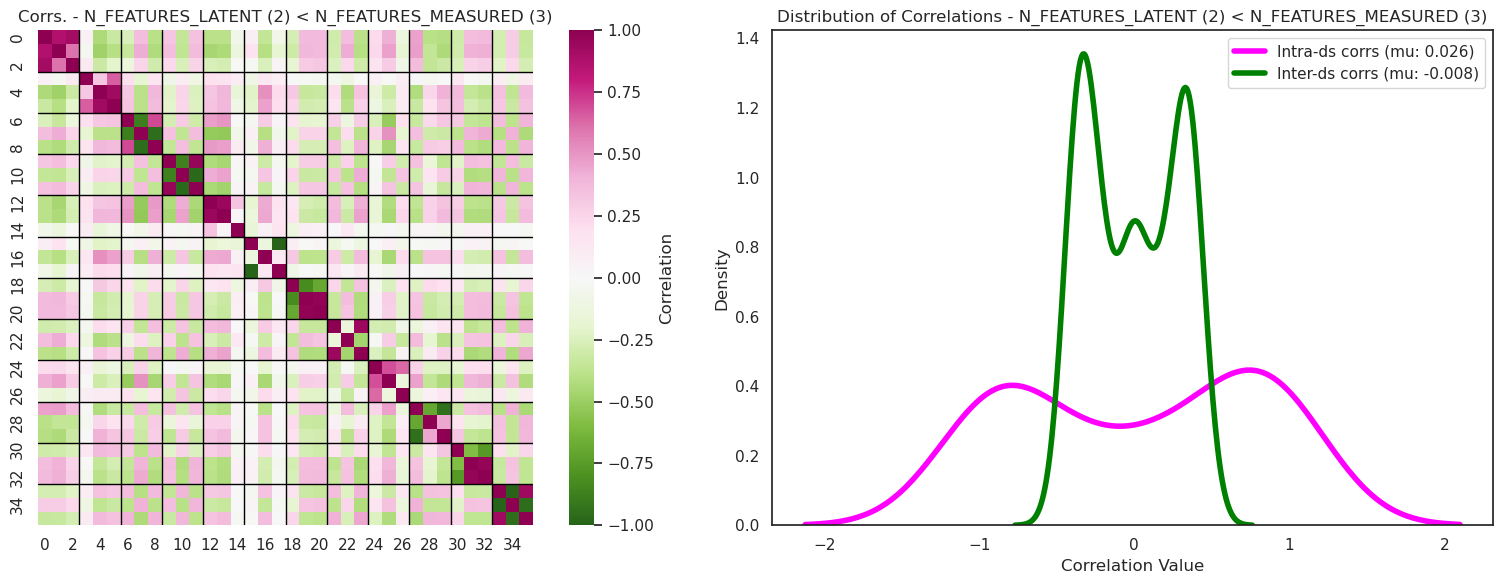

In [22]:
simulator.visualize()

Because these data are 3D, we can plot them for each participant, where each axis is feature, each participant is a color, and each point is a sample. We've included code to plot these as a) scatterplots and b) trajectories in the `demo_data_helpers` file, and will plot them here:

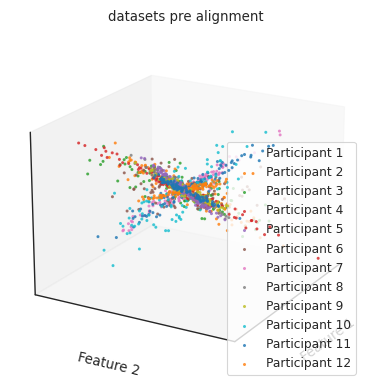

In [23]:
fig, ax = plot_3d_datasets(
        datasets=dss,
        view_angles=(20, 30),
    s=2,
    title='datasets pre alignment'
    )

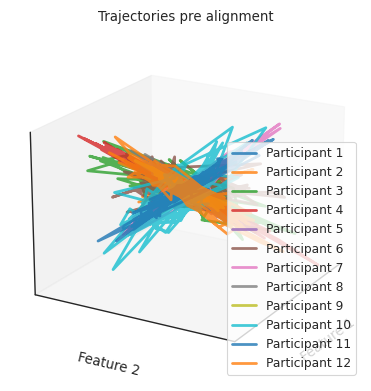

In [24]:
fig, ax = plot_3d_trajectories(
        trajectories=dss,
        view_angles=(20, 30),
    title='Trajectories pre alignment'
    )

As you can see, these datasets seem pretty misaligned along the axes of these three features. Now, let's try hyperaligning this data. Hyperalignment will find a high-dimensional template that captures similarities between the datasets, and derive transformations between the individual datasets to that high-dimensional template. 

In [25]:
# For now, let's use all the default settings
hyp_model = Hyperalignment(verbose=True)
hyp_model.fit(dss)
isc_results=hyp_model.evaluate_isc()

Normalizing data...
Iteration 1, disparity=0.8619
Iteration 2, disparity=0.8619
Iteration 3, disparity=0.8619
Iteration 4, disparity=0.8619
Iteration 5, disparity=0.8619
Iteration 6, disparity=0.8619
Iteration 7, disparity=0.8619
Iteration 8, disparity=0.8619
Iteration 9, disparity=0.8619
Iteration 10, disparity=0.8619
final average disparity: 0.8619
Pre-alignment ISC: -0.0727
Post-alignment ISC: 0.4548


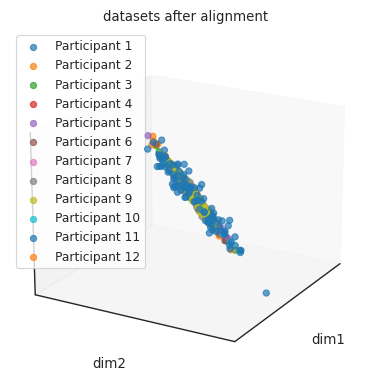

In [26]:
fig, ax = plot_3d_datasets(
        datasets=hyp_model.aligned_data,
    feature_names=['dim1','dim2','dim3'],
    title='datasets after alignment',
        view_angles=(20, 30)
    )

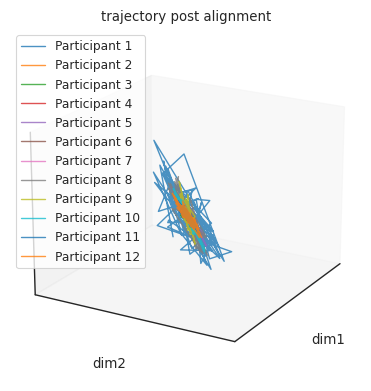

In [19]:
fig, ax = plot_3d_trajectories(
        trajectories=hyp_model.aligned_data,
        view_angles=(20, 30),
    feature_names=['dim1','dim2','dim3'],
        title='trajectory post alignment',
        linewidth=1             # Width of the trajectory lines
    )

## Movie timeseries data
Next we're going to look at data collected while 17 participants watched an episode of BBC's Sherlock in the scanner (accessed from : http://arks.princeton.edu/ark:/88435/dsp01nz8062179). These data were already preprocessed and extracted from an early visual ROI. We are going to demonstrate how to run hyperalignment with cross-validation on these data.

In [39]:
dss = load_sherlock_movie()
labels = load_sherlock_labels()
n_participants, n_trs, n_voxels = dss.shape # 16 participants ,1976 timepoints, 307 voxels
print(dss.shape, labels.shape)

(16, 1976, 307) (1976,)


### Split-half cross validation
For the first form of cross-validation, we are going to use one half of the timeseries, for all participants, to train the hyperalignment model and transformation matrices. Then, we are going to apply those transformation matrices to the second half of the data, and evaluate ISC and between-subject classification accuracy. Cross-validation like this would be used to evaluate that the transformations learned with hyperalignment aren't overfit to the data it received during training, but actually represent something generalizable about each participants' functional organization.

In [40]:
training_dss = dss[:, :n_trs//2, :] # training on first half
testing_dss = dss[:, n_trs//2:, :] # testing on second half
hyp_model = Hyperalignment(verbose=0)
hyp_model.fit(training_dss)

# Apply those transformations to the second half
testing_dss_aligned = hyp_model.transform(testing_dss)

In [41]:
testing_results = hyp_model._run_isc(testing_dss)
testing_results_aligned = hyp_model._run_isc(testing_dss_aligned)
training_results_dict=hyp_model.evaluate_isc()
training_results = training_results_dict['Pre-alignment']
training_results_aligned = training_results_dict['Post-alignment']

In [42]:
# Average results to get one per subject per split
r0 = np.mean(testing_results,axis=1)
r1 = np.mean(testing_results_aligned, axis=1)
r2 = np.mean(training_results, axis=1)
r3 = np.mean(training_results_aligned, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.ones(16), np.zeros(16), np.ones(16)]), 
              'training':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

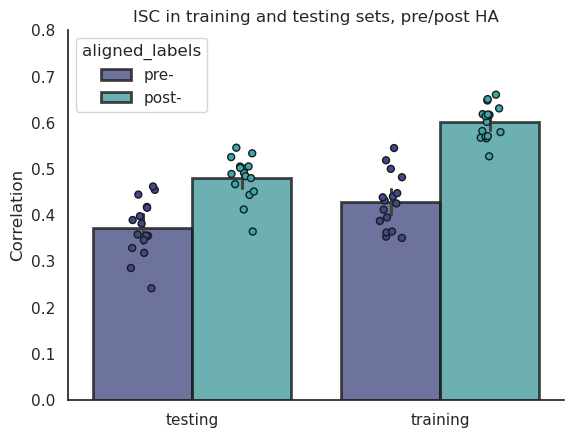

In [43]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=isc_results, x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title='ISC in training and testing sets, pre/post HA')
sns.despine()

What we see here is that hyperalignment improves how synchronized participants' brain responses are with one another. That improvement is greatest in the data that were used to train the hyperalignment (`training` on the x-axis), but the transformations also generalized -- when applied to unseen data (`testing` on the x-axis), we also saw a boost in synchrony.

In [7]:
def random_upsample_train_data(X_train, Y_train):
    '''
    Randomly upsamples training samples so that there are equal samples for each class 
    Helpful for balancing classification problems
    '''
    (unique, counts) = np.unique(Y_train, return_counts=True)
    goal = max(counts)
    train_indices = []
    for ind, classs in enumerate(unique):
        if counts[ind] != goal:
            num2add = goal - counts[ind]
            where_this_class = np.where(Y_train == classs)
            chosen_indices = list(random.choices(where_this_class[0], k=num2add)) + list(where_this_class[0])
            train_indices = train_indices + chosen_indices
        else:
            train_indices += list(np.where(Y_train == classs)[0])
    train_indices.sort()
    X_train = X_train[train_indices]
    Y_train = Y_train[train_indices]
    return X_train, Y_train

In [44]:
df=pd.DataFrame(columns=['fold','aligned','accuracy'])
label_subset = labels[n_trs//2:]
training_labels_orig = np.tile(label_subset, 12)
label_subset1=np.tile(label_subset, 4)
folder=KFold(n_splits=4)
testing_dss_aligned=np.array(testing_dss_aligned)
testing_dss = np.array(testing_dss)
_, ns, nv = testing_dss.shape
kernel='rbf'
C=10
# between subject classification analysis 
for i,(train_idx,test_idx) in enumerate(folder.split(np.arange(16))):
    print(f'Fold {i}, testing on: {test_idx}')

    # train on all other subjects' data; test on held-out    
    clf_training, clf_testing = testing_dss[train_idx].reshape(len(train_idx)*ns,nv), testing_dss[test_idx].reshape(len(test_idx)*ns, nv)
    #clf_training, training_labels = random_upsample_train_data(clf_training, training_labels_orig)
    training_labels=training_labels_orig
    clf_training_aligned, clf_testing_aligned = testing_dss_aligned[train_idx].reshape(len(train_idx)*ns,nv), testing_dss_aligned[test_idx].reshape(len(test_idx)*ns, nv)
    #clf_training_aligned, training_labels = random_upsample_train_data(clf_training_aligned, training_labels_orig)

    print(f'reshaped data: {clf_training.shape}, {clf_testing.shape}, {clf_training_aligned.shape}, {clf_testing_aligned.shape}')
    svc_orig = svm.SVC(C=C, kernel=kernel,class_weight='balanced')
    svc_orig.fit(clf_training, training_labels)
    acc = svc_orig.score(clf_testing, label_subset1)
    print(f'orig={np.round(acc,3)}')
    df.loc[len(df)] = {'fold':i, 'aligned':'pre-', 'accuracy':acc}

    svc_align = svm.SVC(C=C, kernel=kernel, class_weight='balanced')
    svc_align.fit(clf_training_aligned, training_labels)
    acc_align = svc_align.score(clf_testing_aligned, label_subset1)
    df.loc[len(df)] = {'fold':i, 'aligned':'post-', 'accuracy':acc_align}
    print(f'aligned={np.round(acc_align,3)}')
    
    

Fold 0, testing on: [0 1 2 3]
reshaped data: (11856, 307), (3952, 307), (11856, 307), (3952, 307)
orig=0.746
aligned=0.765
Fold 1, testing on: [4 5 6 7]
reshaped data: (11856, 307), (3952, 307), (11856, 307), (3952, 307)
orig=0.732
aligned=0.739
Fold 2, testing on: [ 8  9 10 11]
reshaped data: (11856, 307), (3952, 307), (11856, 307), (3952, 307)
orig=0.714
aligned=0.743
Fold 3, testing on: [12 13 14 15]
reshaped data: (11856, 307), (3952, 307), (11856, 307), (3952, 307)
orig=0.746
aligned=0.75


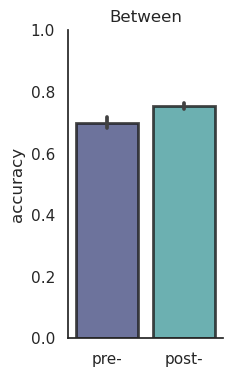

In [10]:
fig,ax=plt.subplots(1,1,figsize=(2,4))
g=sns.barplot(data=df, x='aligned', 
              y='accuracy', 
              order=['pre-','post-'],
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)

g.set(xticklabels=['pre-','post-'], ylim=[0,1], xlabel='', 
      ylabel='accuracy', title='Between-subject classification')
sns.despine()

## Aligning RS-fMRI 

In [25]:
loaded_data=load_rsfmri(20, seed_region=10)

In [26]:
parcellated_data, region_data = np.array(loaded_data['parcellated_all']), np.array(loaded_data['region_all'])
n_timepoints = region_data.shape[1]
parcellated_split_0, region_split_0 = parcellated_data[:, :n_timepoints//2, :], region_data[:, :n_timepoints//2, :]
parcellated_split_1, region_split_1 = parcellated_data[:, n_timepoints//2:, :], region_data[:, n_timepoints//2:, :]

cnx_split0 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_0, region_split_0)]
cnx_split1 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_1, region_split_1)]
print(np.shape(cnx_split0), np.shape(cnx_split1))

(20, 150, 67) (20, 150, 67)


In [27]:
# Train hyperalignment on the first half and transform the second half, and vice-versa
model_split0 = hyp.Hyperalignment(verbose=0)
model_split0.fit(cnx_split0)
aligned_cnx_split1 = model_split0.apply_fit_transformations(cnx_split1)

model_split1 = hyp.Hyperalignment(verbose=0)
model_split1.fit(cnx_split1)
aligned_cnx_split0 = model_split1.apply_fit_transformations(cnx_split0)

In [28]:
# evaluate reliability of connectivity across split-halves
def individual_differences_reliability(cnx0, cnx1):
    pcorr0 = compute_pairwise_corr(cnx0)
    pcorr1 = compute_pairwise_corr(cnx1)
    return np.corrcoef(pcorr0, pcorr1)[0,1]
   
def compute_pairwise_corr(c):
    n,s,t=np.array(c).shape
    c = np.array(c).reshape(n,s*t)
    corrs = pdist(c, 'correlation')
    return corrs

[Text(0.5, 1.0, 'split 1; split-half rel =0.591')]

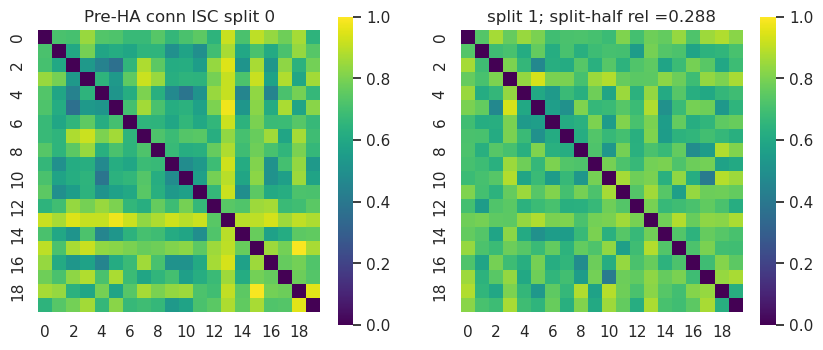

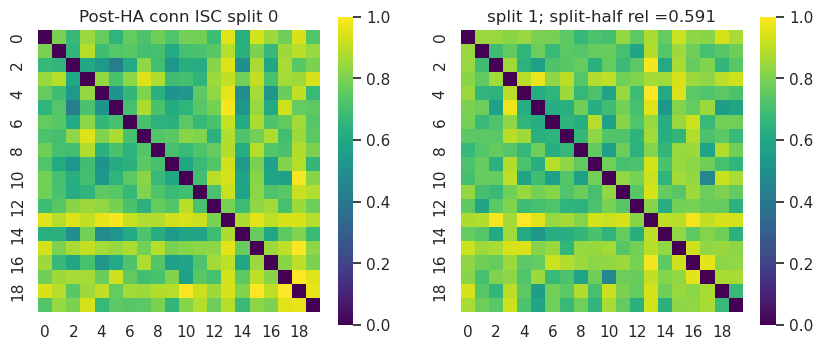

In [29]:
# Running reliability of individual differences across the split halves of data, 
# before and after hyperalignment

pcorr0 = squareform(compute_pairwise_corr(cnx_split0))
pcorr1 = squareform(compute_pairwise_corr(cnx_split1))

fig,ax = plt.subplots(1,2,figsize=(10,4))
r=individual_differences_reliability(cnx_split0, cnx_split1)
g=sns.heatmap(pcorr0, ax=ax[0], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title='Pre-HA conn ISC split 0')
g=sns.heatmap(pcorr1, ax=ax[1], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title=f'split 1; split-half rel ={np.round(r,3)}')


apcorr0 = squareform(compute_pairwise_corr(aligned_cnx_split0))
apcorr1 = squareform(compute_pairwise_corr(aligned_cnx_split1))
r=individual_differences_reliability(aligned_cnx_split0, aligned_cnx_split1)
fig,ax = plt.subplots(1,2,figsize=(10,4))
g=sns.heatmap(apcorr0, ax=ax[0], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title='Post-HA conn ISC split 0')
g=sns.heatmap(apcorr1, ax=ax[1], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title=f'split 1; split-half rel ={np.round(r,3)}')


# Shared response model

## Simulated timeseries data

In [30]:
def run_isc(X):
    '''
    Intersubject correlation analysis: 
    compares each subject's timeseries with the average of all other subjects' timeseries
    Measure of "synchrony" over time across brains, which should be improved by functional alignment
    '''
    if len(np.shape(X)) == 2:
        X = X[:,:,np.newaxis]
    results = np.zeros((len(X), X[0].shape[-1]))
    for i in range(len(X)):
        test = X[i]
        tr_idx = np.setdiff1d(np.arange(len(X)),i)
        train = np.mean(np.array([X[j] for j in tr_idx]), axis=0)
        # get correlation at each feature
        cmat = cdist(test.T, train.T, 'correlation')
        corrs = [1-cmat[i,i] for i in range(cmat.shape[0])]
        results[i]= corrs
    return results

In [31]:
# Create datasets with the following parameters
n_participants, n_samples, n_features = 12, 100, 20
within_corr = 0.8
between_corr = 0.2
noise=0.1

simulator = SimulatedCorrelatedData(n_datasets=n_participants, 
                        n_samples=n_samples, 
                        n_features_measured=n_features,
                        n_features_latent=2,
                       noise_sigma=noise,
                       intra_ds_corr=within_corr,
                       inter_ds_corr=between_corr,
                       verbose=0)
dss = simulator.generate()

# Fit model with 5 features
srm_model = srm.SRM(features=5)

# Have to reshape to be [subjects, features, samples] instead
srm_model.fit([d.T for d in dss])

# Transform the data
srm_data = srm_model.transform([d.T for d in dss])
srm_data = [d.T for d in srm_data]
iscs_srmed = np.mean(run_isc(srm_data),axis=1)
iscs_pre = np.mean(run_isc(dss),axis=1)

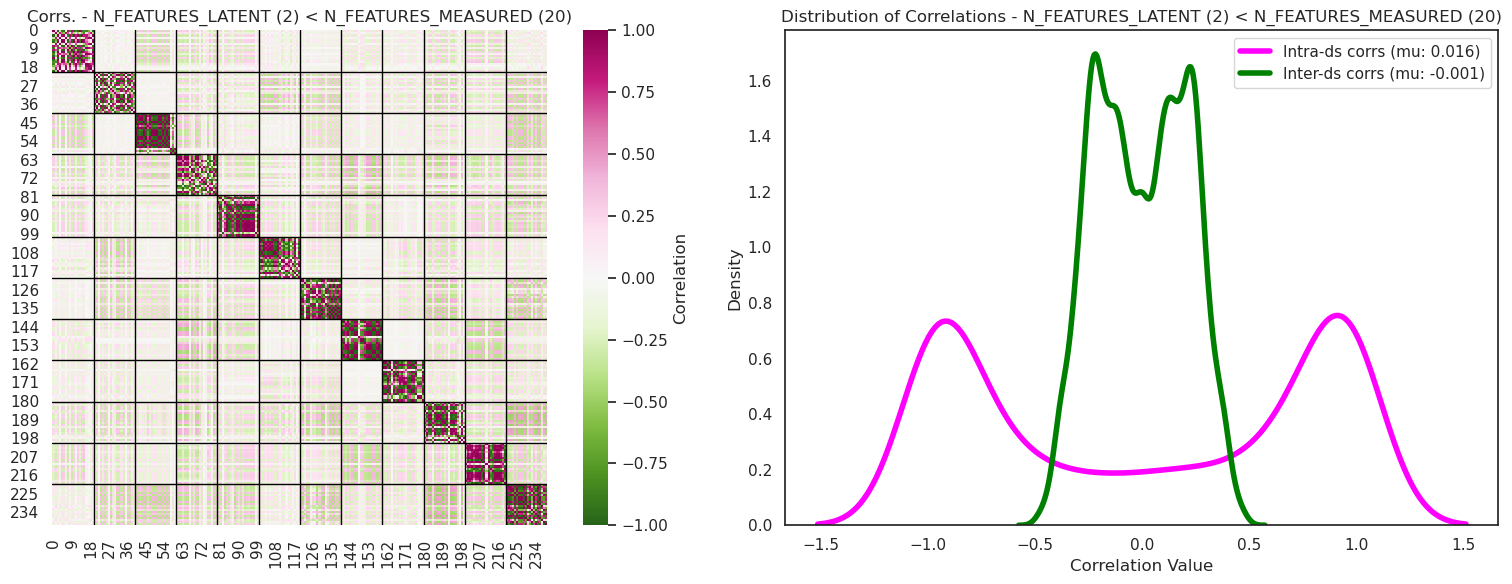

In [32]:
simulator.visualize()

/tmp/ipykernel_3610452/1491266077.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set(xticklabels=['pre-srm','post-srm'], ylabel='correlation')
/tmp/ipykernel_3610452/1491266077.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set(xticklabels=['pre-srm','post-srm'], ylabel='correlation', title='ISC, simulated data')


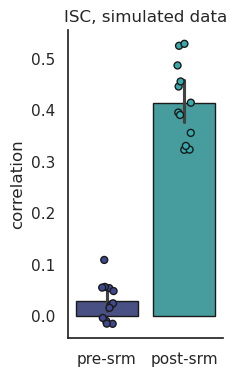

In [33]:
fig,ax=plt.subplots(1,1,figsize=(2,4))

g=sns.barplot([iscs_pre, iscs_srmed], palette='mako', ec='k')
g.set(xticklabels=['pre-srm','post-srm'], ylabel='correlation')
g=sns.stripplot([iscs_pre, iscs_srmed], palette='mako', dodge=False, edgecolor='k', 
                linewidth=1,)
g.set(xticklabels=['pre-srm','post-srm'], ylabel='correlation', title='ISC, simulated data')
sns.despine()

## Movie timeseries data

In [34]:
dss = load_sherlock_movie()
labels = load_sherlock_labels()
n_participants, n_trs, n_voxels = dss.shape # 16 participants ,1976 timepoints, 307 voxels
print(dss.shape, labels.shape)

(16, 1976, 307) (1976,)


In [35]:
training_dss = stats.zscore(dss[:, :n_trs//2, :],axis=1) # training on first half,zscore across timepoints
testing_dss = stats.zscore(dss[:, n_trs//2:, :],axis=1) # testing on second half
srm_model = srm.SRM(features=50)
srm_model.fit([d.T for d in training_dss])

# Transform the training data
srm_training_dss = srm_model.transform([d.T for d in training_dss])
srm_training_dss = np.array([d.T for d in srm_training_dss])

# Transform the testing data
srm_testing_dss = srm_model.transform([d.T for d in testing_dss])
srm_testing_dss = np.array([d.T for d in srm_testing_dss])

# Evaluate intersubject correlations
training_isc = run_isc(training_dss)
testing_isc = run_isc(testing_dss)
srm_training_isc = run_isc(srm_training_dss)
srm_testing_isc = run_isc(srm_testing_dss)

# Average results to get one per subject per split
r0 = np.mean(training_isc,axis=1)
r1 = np.mean(testing_isc, axis=1)
r2 = np.mean(srm_training_isc, axis=1)
r3 = np.mean(srm_testing_isc, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)]), 
              'training':np.concatenate([np.ones(16), np.zeros(16), np.ones(16), np.zeros(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

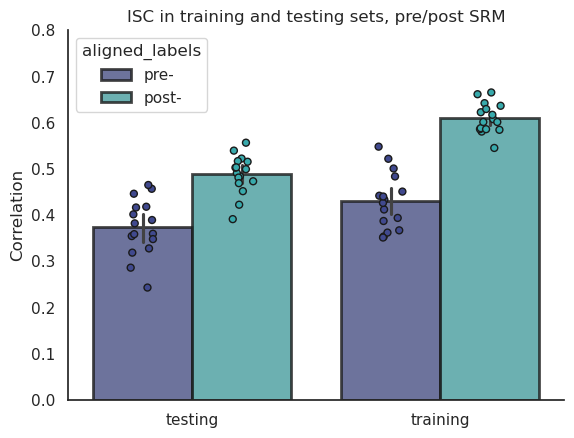

In [47]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=pd.DataFrame(isc_results), x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title='ISC in training and testing sets, pre/post SRM')
sns.despine()

Something else we can do with SRM is tune the number of shared responses learned, with cross-validation. This is how it would work:

In [ ]:
# Iterate through feature hyperparameter and compute ISC on the training data
K_values = np.arange(5, 100, 5)
average_iscs = np.zeros(len(K_values))
for i,k in enumerate(K_values):
    srm_model = srm.SRM(features=k)
    srm_model.fit([d.T for d in training_dss])
    # now score ISC on the training data
    dss_srm = srm_model.transform([d.T for d in training_dss])
    corr = np.mean(run_isc(dss_srm))
    average_iscs[i] = corr

# Choose the K that resulted in the highest isc
maxx = np.argmax(average_iscs)
best_k = K_values[maxx]
srm_model = srm.SRM(features=k)
srm_model.fit([d.T for d in training_dss])
srm_training_dss = srm_model.transform([d.T for d in training_dss])
srm_testing_dss = srm_model.transform([d.T for d in testing_dss])

# Evaluate intersubject correlations
training_isc = run_isc(training_dss)
testing_isc = run_isc(testing_dss)
srm_training_isc = run_isc(srm_training_dss)
srm_testing_isc = run_isc(srm_testing_dss)

# Average results to get one per subject per split
r0 = np.mean(training_isc,axis=1)
r1 = np.mean(testing_isc, axis=1)
r2 = np.mean(srm_training_isc, axis=1)
r3 = np.mean(srm_testing_isc, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)]), 
              'training':np.concatenate([np.ones(16), np.zeros(16), np.ones(16), np.zeros(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

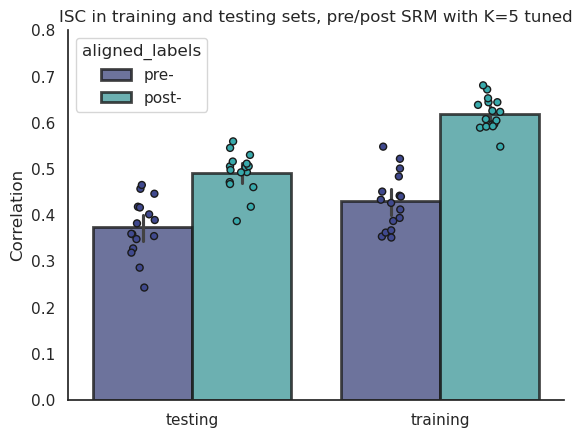

In [51]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=isc_results, x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title=f'ISC in training and testing sets, pre/post SRM with K={best_k} tuned')
sns.despine()

In [50]:
df1=pd.DataFrame(columns=['fold','aligned','accuracy'])
label_subset = labels[n_trs//2:]
training_labels_orig = np.tile(label_subset, 15)
label_subset1=label_subset#np.tile(label_subset, 4)
folder=LeaveOneOut()#KFold(n_splits=4)
testing_dss_aligned=np.array(testing_dss_aligned)
testing_dss = np.array(testing_dss)
_, ns, nv = testing_dss.shape
kernel='rbf'
C=10
# between subject classification analysis 
for i,(train_idx,test_idx) in enumerate(folder.split(np.arange(16))):
    print(f'Fold {i}, testing on: {test_idx}')
    
    clf_training_aligned, clf_testing_aligned = testing_dss_aligned[train_idx].reshape(len(train_idx)*ns,nv), testing_dss_aligned[test_idx].reshape(len(test_idx)*ns, nv)
    clf_training_aligned, training_labels = random_upsample_train_data(clf_training_aligned, training_labels_orig)

    svc_align = svm.SVC(C=C, kernel=kernel, class_weight='balanced')
    svc_align.fit(clf_training_aligned, training_labels)
    acc_align = svc_align.score(clf_testing_aligned, label_subset1)
    df1.loc[len(df1)] = {'fold':i, 'aligned':'post-', 'accuracy':acc_align}
    print(f'aligned={np.round(acc_align,3)}')
    
    

Fold 0, testing on: [0]


NameError: name 'random_upsample_train_data' is not defined

## Aligning RS-fMRI

In [52]:
loaded_data=load_rsfmri(20, seed_region=10)
parcellated_data, region_data = np.array(loaded_data['parcellated_all']), np.array(loaded_data['region_all'])
n_timepoints = region_data.shape[1]
parcellated_split_0, region_split_0 = parcellated_data[:, :n_timepoints//2, :], region_data[:, :n_timepoints//2, :]
parcellated_split_1, region_split_1 = parcellated_data[:, n_timepoints//2:, :], region_data[:, n_timepoints//2:, :]

cnx_split0 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_0, region_split_0)]
cnx_split1 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_1, region_split_1)]
print(np.shape(cnx_split0), np.shape(cnx_split1))

(20, 150, 67) (20, 150, 67)


In [53]:
# Train SRM on the first half and transform the second half, and vice-versa

cnx_split1T = np.array([c for c in cnx_split1])
cnx_split0T = np.array([c for c in cnx_split0]) # reshape 

model_split0 = srm.SRM(features=20)
model_split0.fit(cnx_split0T)

aligned_cnx_split1 = model_split0.transform(cnx_split1T)
aligned_cnx_split1 = np.array([s for s in aligned_cnx_split1])


model_split1 = srm.SRM(features=20)
model_split1.fit(cnx_split1T)

aligned_cnx_split0 = model_split1.transform(cnx_split0T)
aligned_cnx_split0 = np.array([s for s in aligned_cnx_split0])

In [54]:
# evaluate reliability of connectivity across split-halves
def individual_differences_reliability(cnx0, cnx1):
    pcorr0 = compute_pairwise_corr(cnx0)
    pcorr1 = compute_pairwise_corr(cnx1)
    return np.corrcoef(pcorr0, pcorr1)[0,1]
   
def compute_pairwise_corr(c):
    n,s,t=np.array(c).shape
    c = np.array(c).reshape(n,s*t)
    corrs = pdist(c, 'correlation')
    return corrs

[Text(0.5, 1.0, 'Post-SRM corr. diff. split 1; rel = 0.249')]

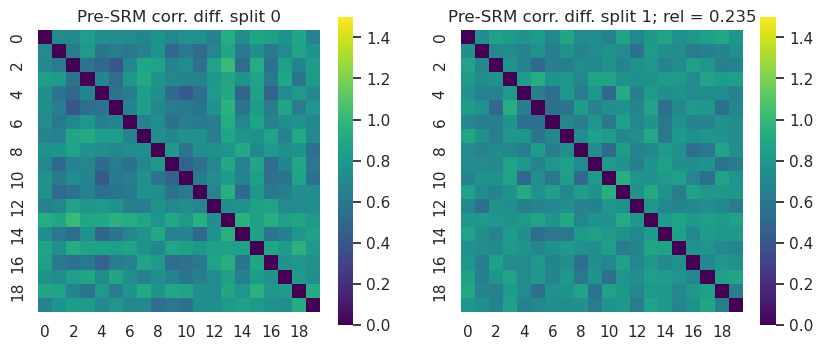

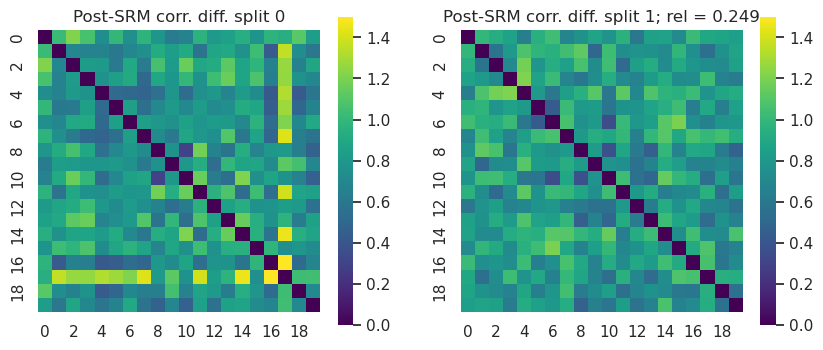

In [55]:
# Running reliability of individual differences across the split halves of data, 
# before and after hyperalignment

pcorr0 = squareform(compute_pairwise_corr(cnx_split0))
pcorr1 = squareform(compute_pairwise_corr(cnx_split1))

fig,ax = plt.subplots(1,2,figsize=(10,4))
r=individual_differences_reliability(cnx_split0, cnx_split1)
g=sns.heatmap(pcorr0, ax=ax[0], vmin=0, vmax=1.5, cmap='viridis', square=True)
g.set(title='Pre-SRM corr. diff. split 0')
g=sns.heatmap(pcorr1, ax=ax[1], vmin=0, vmax=1.5, cmap='viridis', square=True)
g.set(title=f'Pre-SRM corr. diff. split 1; rel = {np.round(r,3)}')


apcorr0 = squareform(compute_pairwise_corr(aligned_cnx_split0))
apcorr1 = squareform(compute_pairwise_corr(aligned_cnx_split1))
r=individual_differences_reliability(aligned_cnx_split0, aligned_cnx_split1)
fig,ax = plt.subplots(1,2,figsize=(10,4))
g=sns.heatmap(apcorr0, ax=ax[0], vmin=0, vmax=1.5, cmap='viridis', square=True)
g.set(title=f'Post-SRM corr. diff. split 0')
g=sns.heatmap(apcorr1, ax=ax[1], vmin=0, vmax=1.5, cmap='viridis', square=True)
g.set(title=f'Post-SRM corr. diff. split 1; rel = {np.round(r,3)}')
